# 6. Image co-registration

One of the most important steps in MRS processing is visualising the spectroscopy region on a structural image. This not only allows us to validate that the voxel was correctly placed and assess any partial volume effects, but can also be used to estimate the mean T2 of the voxel from the gray and white matter content (for brain spectroscopy). Quantification tools use the T2 to correct for signal relaxation and adjust the metabolite concentrations, but by default they use a generic value. By calculating your own from the voxel location, you can get more accurate concentrations. Co-registration is also particularly important for spectroscopic imaging, for example when generating heatmap overlays on top of structural images.

In this tutorial, we will look at how to relate the coordinate systems of the scanner, the image and the spectroscopy together, and how to plot a simple voxel outline on top of an image slice. In later tutorials, we will see how to use this for T2 estimation, and look at more advanced renderings for CSI data.

In [1]:
import suspect
import numpy as np
import matplotlib.pyplot as plt

Loading structural MR images is handled by the `suspect.image` module. Currently, suspect only supports working with DICOM files, although support for NIFTI and other formats is planned for the future. The `load_dicom_volume()` function finds all the DICOM files in the directory of the specified file which have the same SeriesUID, and loads them all into a single 3D volume of the `ImageBase` class.

In [2]:
t1 = suspect.image.load_dicom_volume("mprage/IM-0001-0001.IMA")

Like the MRSData class, the ImageBase class is a numpy.ndarray subclass with a few extra helper functions. This makes it very easy to display image slices using matplotlib's `imshow()` function.

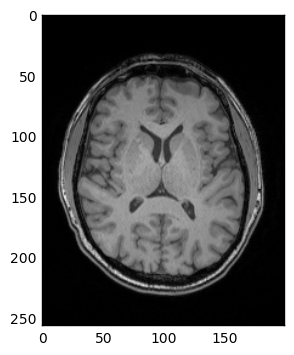

In [3]:
plt.imshow(t1[100], cmap=plt.cm.gray)

For this tutorial, the two most important functions we are going to look at are `to_scanner()` and `from_scanner()`. These functions are used to convert between the voxel coordinate system of the image, and the intrinsic coordinates of the scanner. For example, we can take the bottom left hand voxel of the image: (0, 0, 0) and see where that is located inside the scanner.

In [4]:
origin_position = t1.to_scanner(0, 0, 0)
print(origin_position)

[ -99.75786927 -130.17917679 -103.61138058]


`origin_position` gives us the location of the (0, 0, 0) voxel relative to the scanner isocenter, in mm, using the standard scanner coordinates, with x increasing from right to left, y increasing from anterior to posterior and z increasing from inferior to superior.

On the other hand, we can also work out which voxel is closest to isocenter using the `from_scanner()` function.

In [5]:
isocenter_voxel = t1.from_scanner(0, 0, 0)
print(isocenter_voxel)

[  99.75786924  130.17917681  103.61138058]


Note that we don't get integer values for the voxel coordinates, this is important when we want to chain coordinate systems together later on. However, if we want to slice into our volume we can convert them to integers (making sure to round first so that e.g. 99.75 goes to 100 and not 99):

In [6]:
isocenter_indices = isocenter_voxel.round().astype(int)
print(isocenter_indices)

[100 130 104]


A quick word here about `ImageBase` coordinates. Conceptually suspect loads the DICOM volume as a stack of slices which means that voxels are indexed as `volume[slice, row, column]`. This is done to make it easier to plot the images with matplotlib where the outer dimension is the vertical. However, the `to_scanner()` and `from_scanner()` functions both stick to the standard order of x, y, z, or column, row, slice. Therefore when accessing a particular slice of an image, the coordinates must be reversed. This is confusing but better than any of the alternatives so far proposed.

Now that we have seen how to load an image and understand its coordinate systems, it is time to look at the spectroscopy side. Fortunately, `MRSData` is a subclass of `ImageBase`, so the spectroscopy object has exactly the same `to_scanner()` and `from_scanner()` methods available. In this example, we will be using a voxel acquired from the posterior cingulate gyrus, in the rda format.

In [7]:
pcg = suspect.io.load_rda("pcg.rda")

pcg_centre = pcg.to_scanner(0, 0, 0)
print(pcg_centre)

[ -2.542373  43.220339  21.186441]


As we can see, this voxel is located slightly behind and above the isocenter position. Now that we know the location of the centre of the voxel in scanner coordinates, we can convert that into the image space to tell us which slice goes through the middle of the voxel.

In [8]:
pcg_centre_index = t1.from_scanner(*pcg_centre).round().astype(int)
print(pcg_centre_index)

[ 97 173 125]


This tells us that slice 125 goes through the centre of the voxel. In this case the voxel is aligned with the plane of the image, so we don't have to worry about drawing all the sides. Instead we will draw the transverse slice through the middle of the voxel, as shown in this diagram.

![voxel](cube.pdf)

In [9]:
corner_coords_pcg = [[-0.5, -0.5, 0],
                     [0.5, -0.5, 0],
                     [0.5, 0.5, 0],
                     [-0.5, 0.5, 0],
                     [-0.5, -0.5, 0]]
corner_coords = np.array([t1.from_scanner(*pcg.to_scanner(*coord)) for coord in corner_coords_pcg])

We start with the list of points in the spectroscopy voxel coordinates. Note that we have added a second copy of the first point at the end to make it easier to plot a loop. We then use a list comprehension to convert each point first into the scanner coordinates and then into the image space. Finally we convert the list of coordinates into a numpy array to make it easier to access the data from matplotlib.

Now we are ready to plot the voxel. We start by displaying the correct image slice with `imshow()`, then pass the x and y coordinates of the voxel to `plot()`. As a final touch, we use the `xlim()` and `ylim()` functions to restrict the axes only to the image range, otherwise matplotlib will pad the image with blank space.

(255, 0)

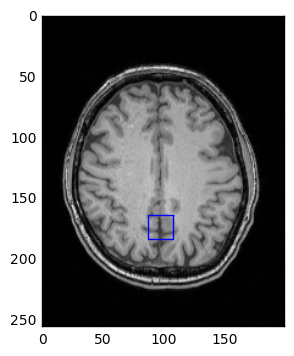

In [10]:
plt.imshow(t1[pcg_centre_index[2]], cmap=plt.cm.gray)
plt.plot(corner_coords[:, 0], corner_coords[:, 1])
plt.xlim([0, t1.shape[2] - 1])
plt.ylim([t1.shape[1] - 1, 0])

And that is really all there is to it. Now that we know how to convert spectroscopy points into image space, it is very easy to get the voxel on coronal or sagittal images as well. We just have to change the points on the spectroscopy voxel and take a different slice through the image volume. The one important thing to remember is that for sagittal and coronal images the vertical axis is z, which increases from inferior to superior, unlike the default in matplotlib where images are plotted downwards. This means we have to use `ylim()` to reverse the direction of plotting, to get our images the right way up.

(0, 191)

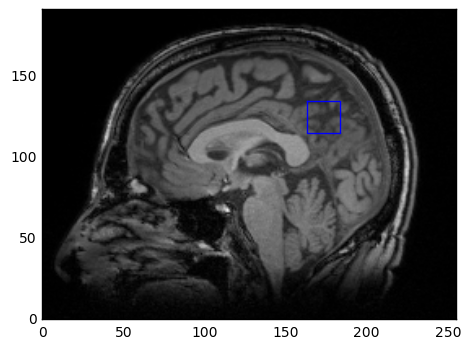

In [11]:
sagittal_voxel = [[0, -0.5, -0.5], [0, 0.5, -0.5], [0, 0.5, 0.5], [0, -0.5, 0.5], [0, -0.5, -0.5]]
sagittal_positions = np.array([t1.from_scanner(*pcg.to_scanner(*coord)) for coord in sagittal_voxel])
plt.imshow(t1[:, :, pcg_centre_index[0]], cmap=plt.cm.gray)
plt.plot(sagittal_positions[:, 1], sagittal_positions[:, 2])
plt.xlim([0, t1.shape[1] - 1])
plt.ylim([0, t1.shape[0] - 1])